In [1]:
import numpy as np
import pandas as pd
import torch
from NashAgent_lib import *
from RAT_env import *
from NashRL import *
import matplotlib.pyplot as plt

def evaluate_action_network(rat_env, action_network, n_episodes):
    
    action_network.eval()

    reward_buffer = []
    action_buffer = []
    for i in range(n_episodes):
        rat_env.reset()
        for t in range(0,100): #10 steps in each env (user moving)
            current_state, _, _ = rat_env.get_state()
            state = expand_list(current_state,rat_env.n_users)
            action_list = action_network.forward(input=state)
            action_list = torch.hstack([torch.abs(action_list[:, 0]).view(-1,1), action_list[:, 1].view(-1,1), torch.abs(action_list[:, 2]).view(-1,1), action_list[:, 3:]])
            a = action_list[:,4].detach()
            a = torch.clamp(a, min=0, max=(rat_env.n_stations-1))
            _, actions , _, reward = rat_env.step(a.detach())
            action_buffer.append(actions)
            reward_buffer.append(reward)
    
    return reward_buffer,action_buffer



def plot_reward(reward_buffer):
    n_runs = len(reward_buffer)
    n_agents = len(reward_buffer[0])
    
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))

    for i in range(n_agents):
        ax = axes[i // 5, i % 5]
        agent_rewards = np.array([reward_buffer[run][i] for run in range(n_runs)])
        
        ax.plot(range(n_runs), agent_rewards, label=f"Agent {i+1}")

        ax.set_title(f"Agent {i+1}")
        ax.set_xlabel("Run")
        ax.set_ylabel("Reward")
        ax.grid(True)
        ax.legend()

    fig.suptitle("Reward Evolution for Each Agent Across Runs", fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_actions(actions_buffer):
    n_runs = len(actions_buffer)
    n_agents = len(actions_buffer[0])
    
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))

    for i in range(n_agents):
        ax = axes[i // 5, i % 5]
        agent_actions = np.array([int(torch.round(actions_buffer[run][i])) for run in range(n_runs)])
        ax.plot(range(n_runs), agent_actions, label=f"Agent {i+1}")

        ax.set_title(f"Agent {i+1}")
        ax.set_xlabel("Run")
        ax.set_ylabel("Station chosen")
        ax.grid(True)
        ax.legend()

    fig.suptitle("Stations Chosen by Each Agent Across Runs", fontsize=16)
    plt.tight_layout()
    plt.show()

Initialize enviroment

c:\Users\alvar\Documents\TELECO\cuarto\Thesis\Nash_DQN_RAT\RAT_env.py:346: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(position[0], position[1], c=color, label=f'User (RAT {rat})', s=10)


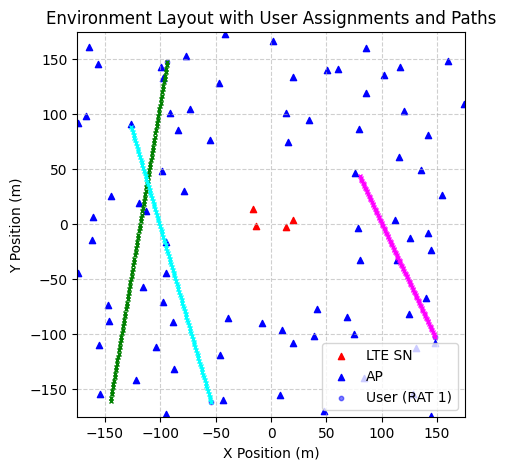

In [2]:
# Parameters for the Multi-RAT Network
user_area_width = 100
ltesn_area_width = 50
n_aps = 81
n_users = 3
n_steps = 100
cqi_dataset = pd.read_csv("cqi_distance.csv")
rssi_dataset = pd.read_csv("rssi_distance.csv")

rat_env = Multi_RAT_Network(user_area_width, ltesn_area_width, n_users, n_aps, cqi_dataset, rssi_dataset, n_steps, plot=True)

In [3]:
action_network = PermInvariantQNN(n_users = rat_env.n_users, n_stations = rat_env.n_stations, out_dim=5, lat_dims=128, layers=4)
action_network.load_state_dict(torch.load(r"C:\Users\alvar\Documents\TELECO\cuarto\Thesis\Nash_DQN_RAT\Action_Net.pt"))
rewards,actions = evaluate_action_network(rat_env, action_network, n_episodes = 15)

C:\Users\alvar\AppData\Local\Temp\ipykernel_21856\4221854750.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  action_network.load_state_dict(torch.load(r"C:\Users\alvar\D

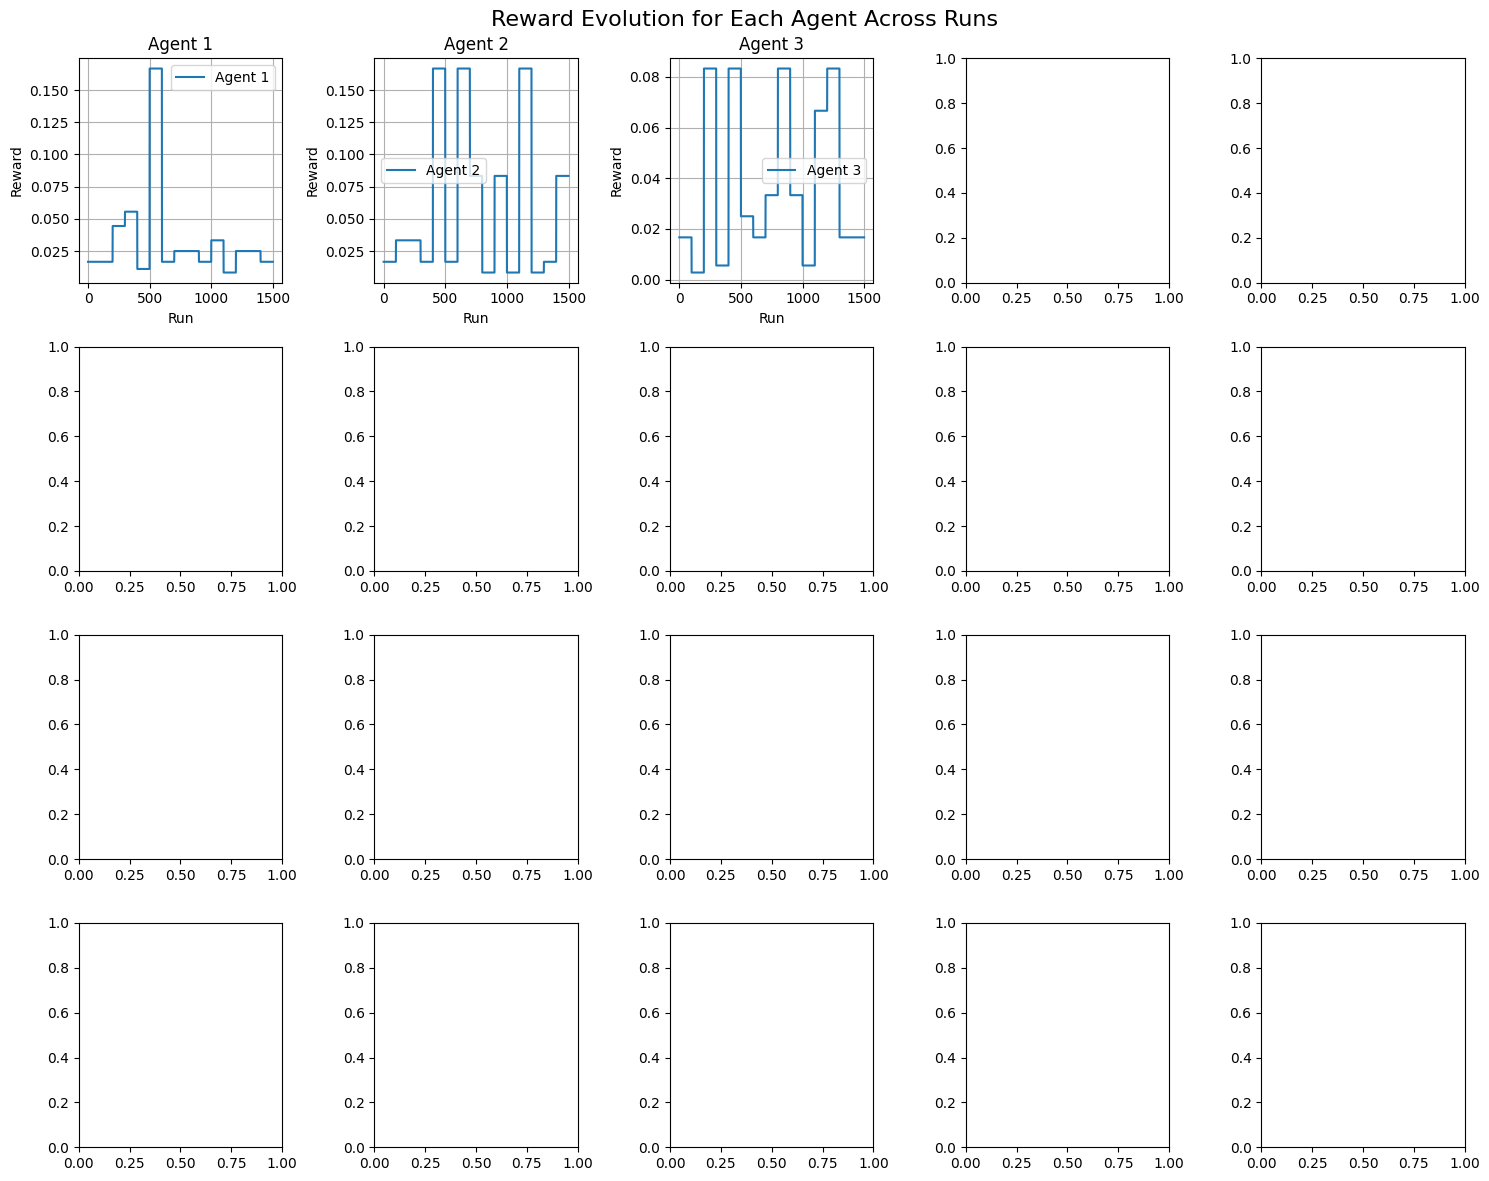

In [4]:
plot_reward(rewards)

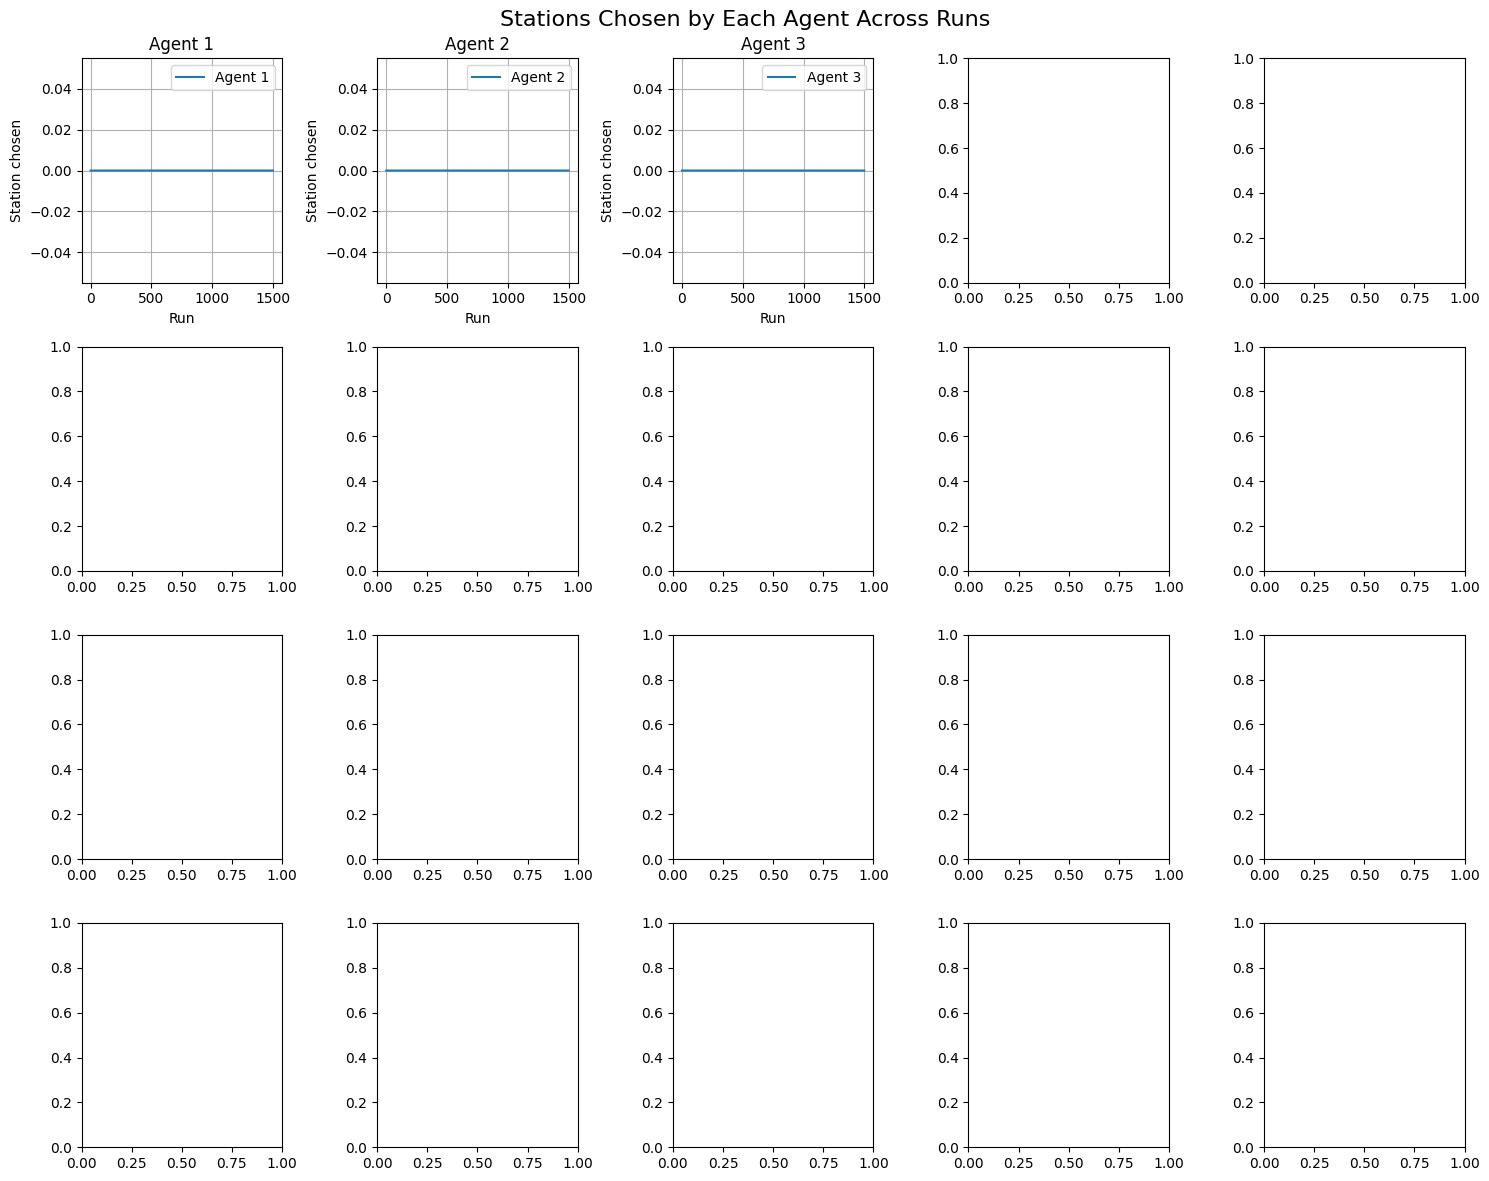

In [5]:
plot_actions(actions)